In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore
import bambi as bmb
import arviz as az
import bammm.bammm as mm
import matplotlib.pyplot as plt
import networkx as nx
import json
from itertools import product, combinations
import statsmodels.formula.api as smf



# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]
corr_type = "spearman"

no_trait_factors = 4
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==4:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
        #trait_factor_names_short = ["TF3", "TF2", "TF1","TA"]
        trait_factor_names_short = ["TF3", "TF2", "TF1"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 


mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Probest',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'DangerState',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }


datavars = "focused" # "fullFA" / "focused"
if datavars == "full":
        vars = ["Worry", "Probest", 
        "AvoidBeh", "AvoidAnx", "InforSeek", 
        "DangerSate", "Deaths","Cases"]
elif datavars == "fullFA": 
        vars = ["F1_exposure_anxiety","F2_covid_worry", "F3_infection_probability",  
                "F4_mixed_IS_closep", "F5_danger_perception", "F6_econ_worry", 
                "F7_skepticism", "F8_time_end_estimates", "F9_avoidance",  "Deaths","Cases"]
elif datavars == "focused": 
        vars = [ "AvoidBeh", "InforSeek","DangerState","Probest", "Deaths","Cases"]


df=df.rename(columns=mapdict)
dfall = df.copy()

df.loc[:,vars] = df.loc[:,vars].apply(zscore, nan_policy='omit')
df = df.loc[:,vars+["PROLIFICID","session"]]
#tdf = df.pivot(columns="session", index="PROLIFICID", values=vars+vars_factors)

id_df = dfall.loc[:,["PROLIFICID","TF3", "TF2", "TF1", "TA"]].groupby(by=["PROLIFICID"]).mean()

/data/drive/postdoc/Project4_covid


In [4]:
contemp_df = pd.read_csv(os.path.join(root_dir, "output", "working_data", "individual_contemp_network.csv"))
contemp_df = contemp_df.set_index("PROLIFICID").join(id_df)
# filter 


temp_df = pd.read_csv(os.path.join(root_dir, "output", "working_data", "individual_temp_network.csv"))
temp_df = temp_df.set_index("PROLIFICID").join(id_df)

Unnamed: 0        iv           dv      edge        PROLIFICID
0              1  AvoidBeh     AvoidBeh  0.302992  01S0stEpc3rU6YxK
1              2  AvoidBeh    InforSeek  0.000000  01S0stEpc3rU6YxK
2              3  AvoidBeh      Probest  0.000000  01S0stEpc3rU6YxK
3              4  AvoidBeh  DangerState -0.530696  01S0stEpc3rU6YxK
4              5  AvoidBeh       Deaths  0.268364  01S0stEpc3rU6YxK
...          ...       ...          ...       ...               ...
9355        9356     Cases    InforSeek  0.000000  ztPVSoIVH3QKpGeQ
9356        9357     Cases      Probest  0.000000  ztPVSoIVH3QKpGeQ
9357        9358     Cases  DangerState  0.000000  ztPVSoIVH3QKpGeQ
9358        9359     Cases       Deaths  0.207019  ztPVSoIVH3QKpGeQ
9359        9360     Cases        Cases  0.546168  ztPVSoIVH3QKpGeQ

[9360 rows x 5 columns]

### Plot raw correlations
(I suspect a LOT of zero inflation downplaying the effects)

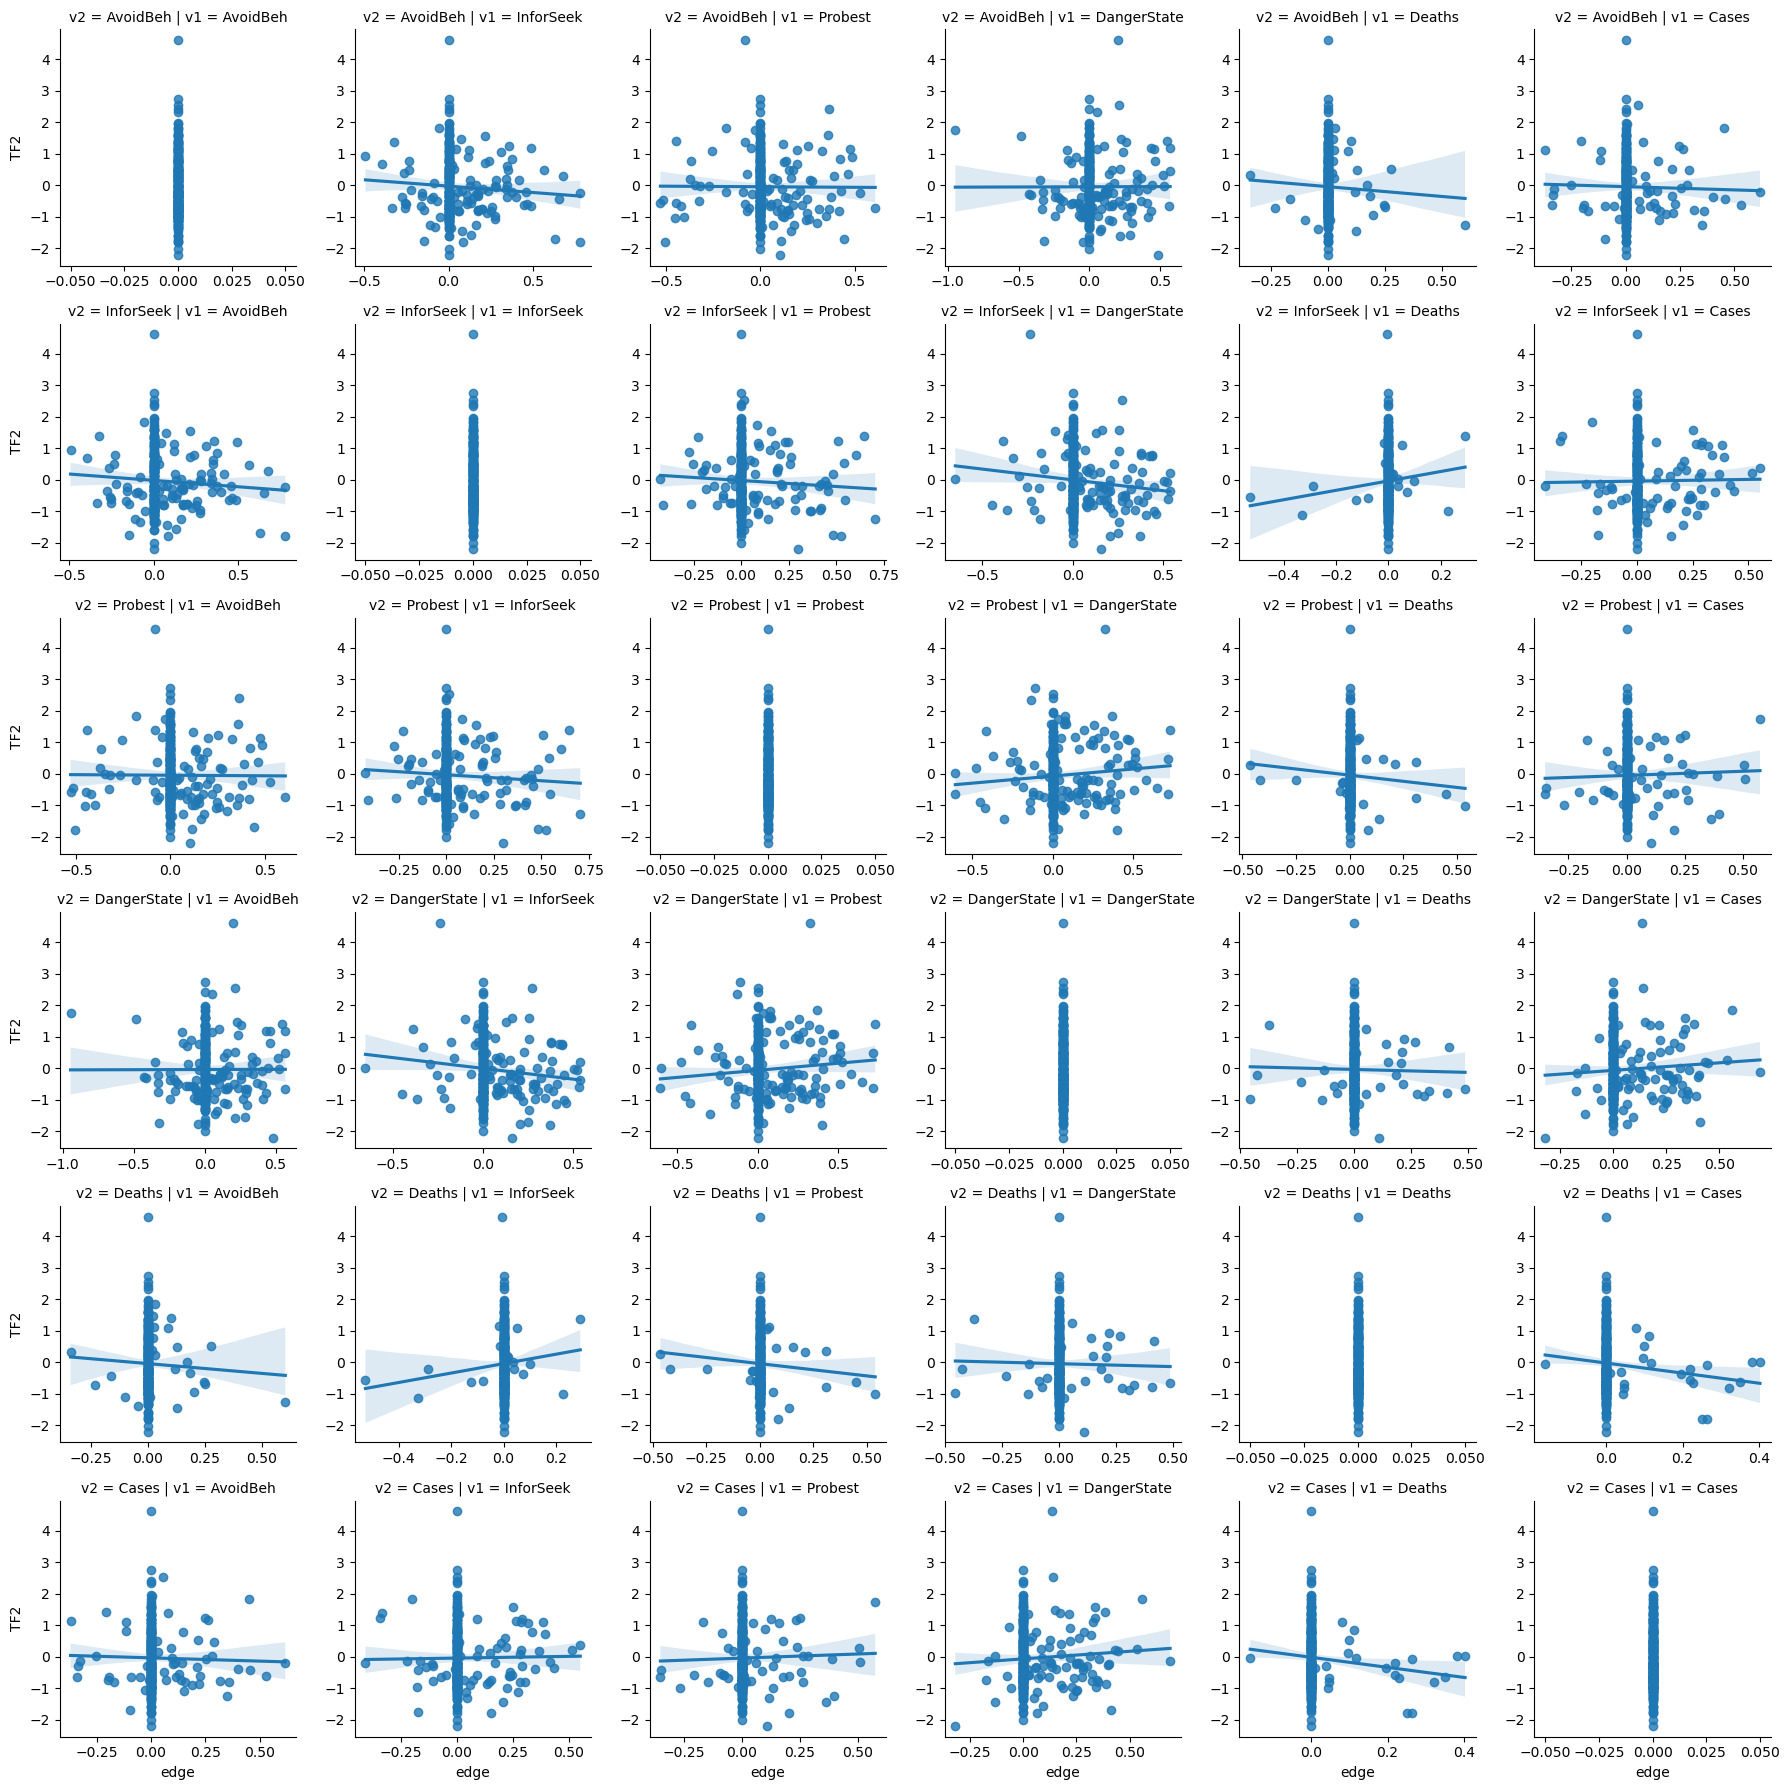

In [6]:
sns.lmplot(
    data=contemp_df, x="edge", y="TF2",
    col="v1", row="v2", height=3,
    facet_kws=dict(sharex=False, sharey=False),
)

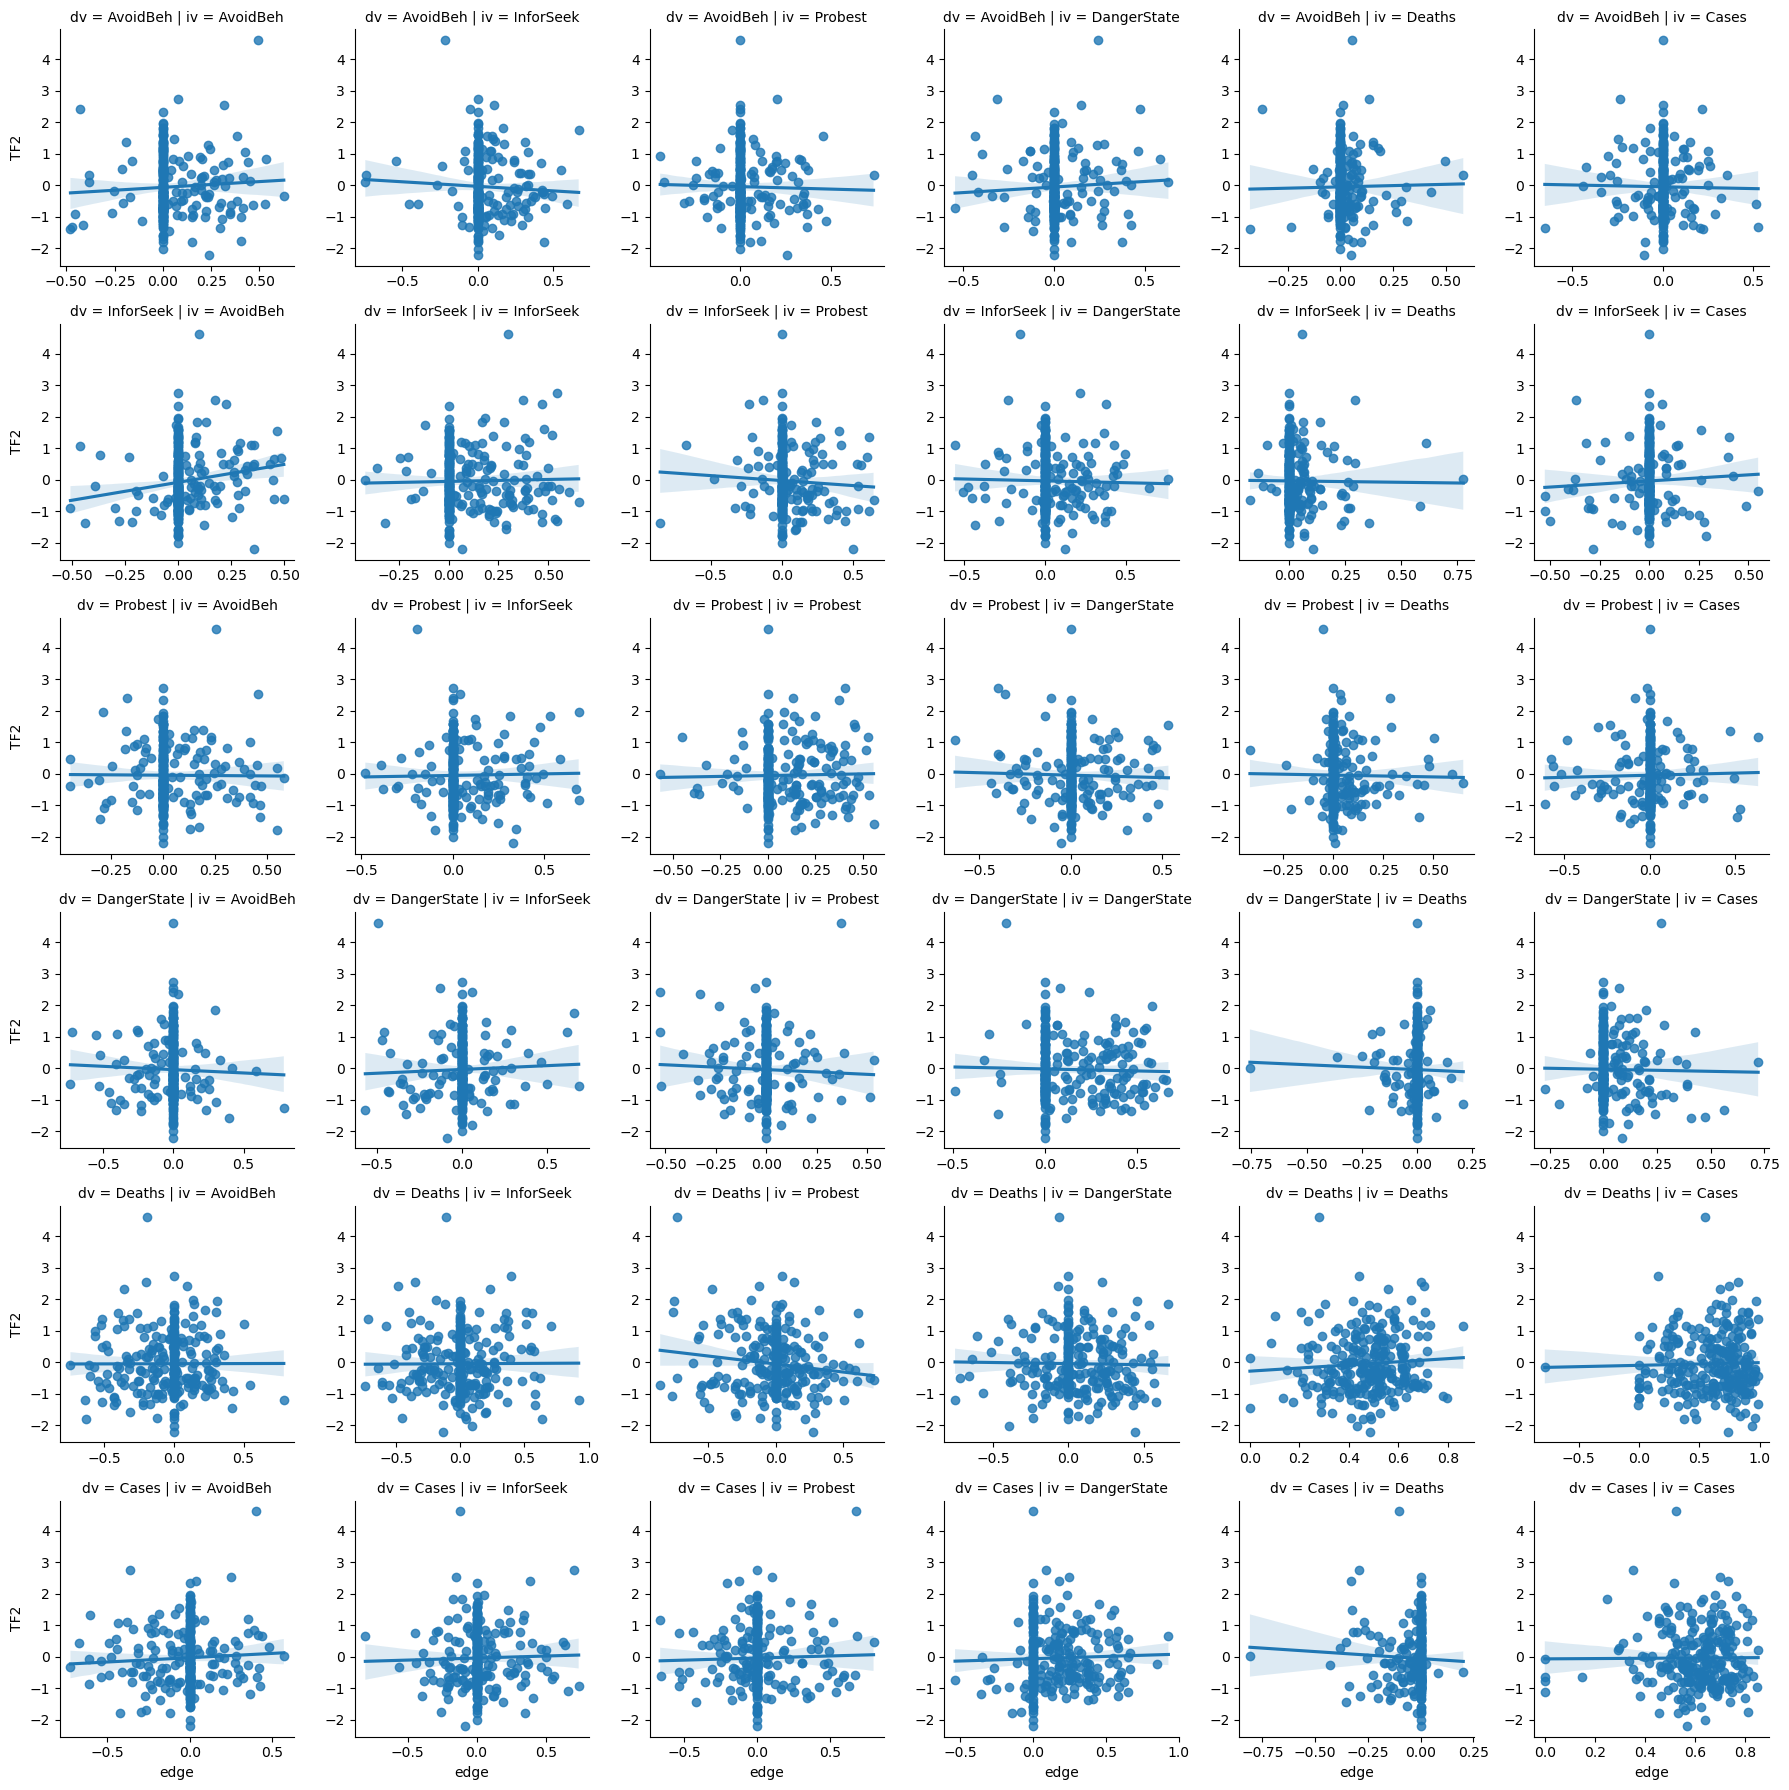

In [5]:
sns.lmplot(
    data=temp_df, x="edge", y="TF2",
    col="iv", row="dv", height=3,
    facet_kws=dict(sharex=False, sharey=False),
)

In [ ]:
contemp_df

Unnamed: 0        v1           v2      edge       TF3  \
PROLIFICID                                                                
01S0stEpc3rU6YxK           1  AvoidBeh     AvoidBeh  0.000000 -0.045855   
01S0stEpc3rU6YxK           2  AvoidBeh    InforSeek  0.135037 -0.045855   
01S0stEpc3rU6YxK           3  AvoidBeh      Probest -0.529799 -0.045855   
01S0stEpc3rU6YxK           4  AvoidBeh  DangerState -0.080946 -0.045855   
01S0stEpc3rU6YxK           5  AvoidBeh       Deaths  0.000000 -0.045855   
...                      ...       ...          ...       ...       ...   
ztPVSoIVH3QKpGeQ        9356     Cases    InforSeek  0.280980 -1.471485   
ztPVSoIVH3QKpGeQ        9357     Cases      Probest  0.000000 -1.471485   
ztPVSoIVH3QKpGeQ        9358     Cases  DangerState  0.175793 -1.471485   
ztPVSoIVH3QKpGeQ        9359     Cases       Deaths  0.000000 -1.471485   
ztPVSoIVH3QKpGeQ        9360     Cases        Cases  0.000000 -1.471485   

                       TF2       TF1         TA  
PROLIFICID                                       
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
01S0stEpc3rU6YxK -0.573207  0.000099  48.666667  
...                    ...       ...        ...  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  
ztPVSoIVH3QKpGeQ  0.071957 -0.726433  31.333333  

[9360 rows x 8 columns]

## Contemporaneouse netowrk - reconstructed from single subject networks 

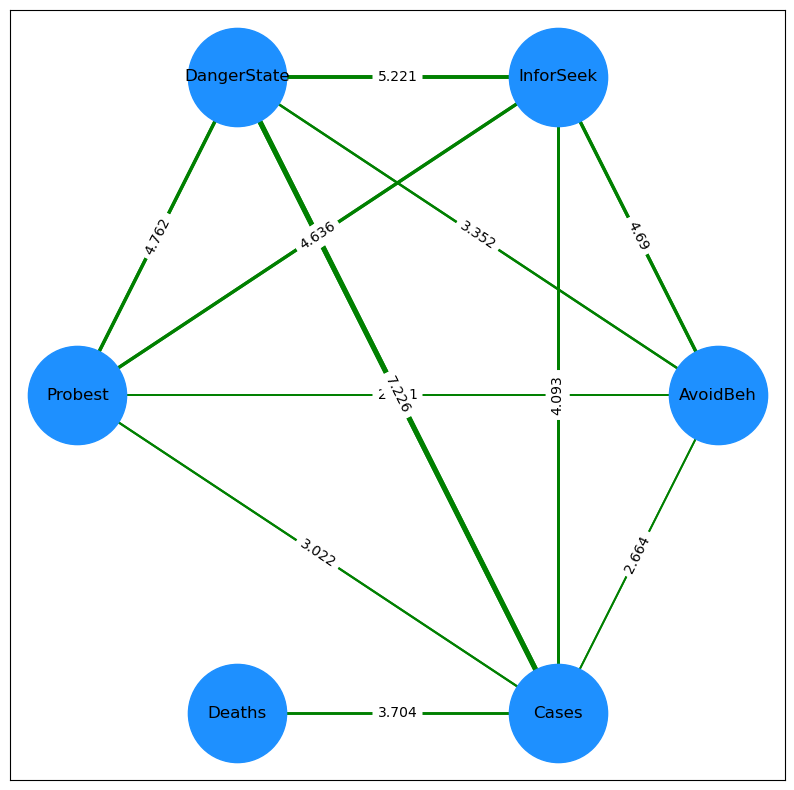

In [ ]:
# get data
v2s = "T"
def extract_values(row):
    return pd.Series(row['CI95%'])

# get unique combinations (for unidirectional plots)
combs = pd.DataFrame(list(product(vars, vars)), columns=['v1', 'v2'])
idx = np.array(combs["v1"] != combs["v2"])
combs = combs.loc[idx].reset_index()

# calcualte t-tests
bounds = contemp_df.groupby(by=["v1", "v2"])['edge'].apply(pg.ttest, 0, paired=False).round(3).reset_index()

# make sure only unique combinations of v1 and v2 exist
bounds = pd.merge(combs, bounds, on=["v1", "v2"], how="left")

# estimate betas
bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

# do multiple comparison
ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"].astype(float), method="fdr_bh")).T
ffdf.columns =["H", "corr_p"]
bounds = pd.concat([bounds,ffdf ], axis=1)

# filter for only significant relationships
bounds["sig"]  = ["ns" if p>=0.05 else "s" for p in bounds["corr_p"]]
bounds = bounds.loc[bounds["sig"]=="s",:]
sigcombs = dict([((v1, v2), "x") for v1, v2 in zip(bounds["v1"], bounds["v2"])])
edge_colors = ["green" if x>=0 else "red" for x in bounds[v2s]]


import matplotlib
import matplotlib.cm as cm

# Prepare bodes, edges and layouts 
G = nx.DiGraph()
G.add_nodes_from(vars)
G.add_edges_from(sigcombs)
edge_labels = dict([((v1, v2), round(float(bounds.loc[(bounds["v1"]==v1) & (bounds["v2"]==v2),v2s]),3)) for v1, v2 in zip(bounds["v1"],bounds["v2"])])
edge_widths = np.array([round(float(bounds.loc[(bounds["v1"]==v1) & (bounds["v2"]==v2),v2s]),3) for v1, v2 in zip(bounds["v1"],bounds["v2"])])

nodesize = 5000
arc_rad = 0
pos=nx.circular_layout(G)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
nx.draw_networkx_labels(G, pos, ax=ax)

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*0.5, edgelist=sigcombs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=False, arrowsize=10, node_size=nodesize)
#fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)
#ax.set_title(lbl + "(t-scores)")
plt.show()

## Contemporansous correlations with traits

In [ ]:
contemp_df = contemp_df.set_index("PROLIFICID").join(id_df)


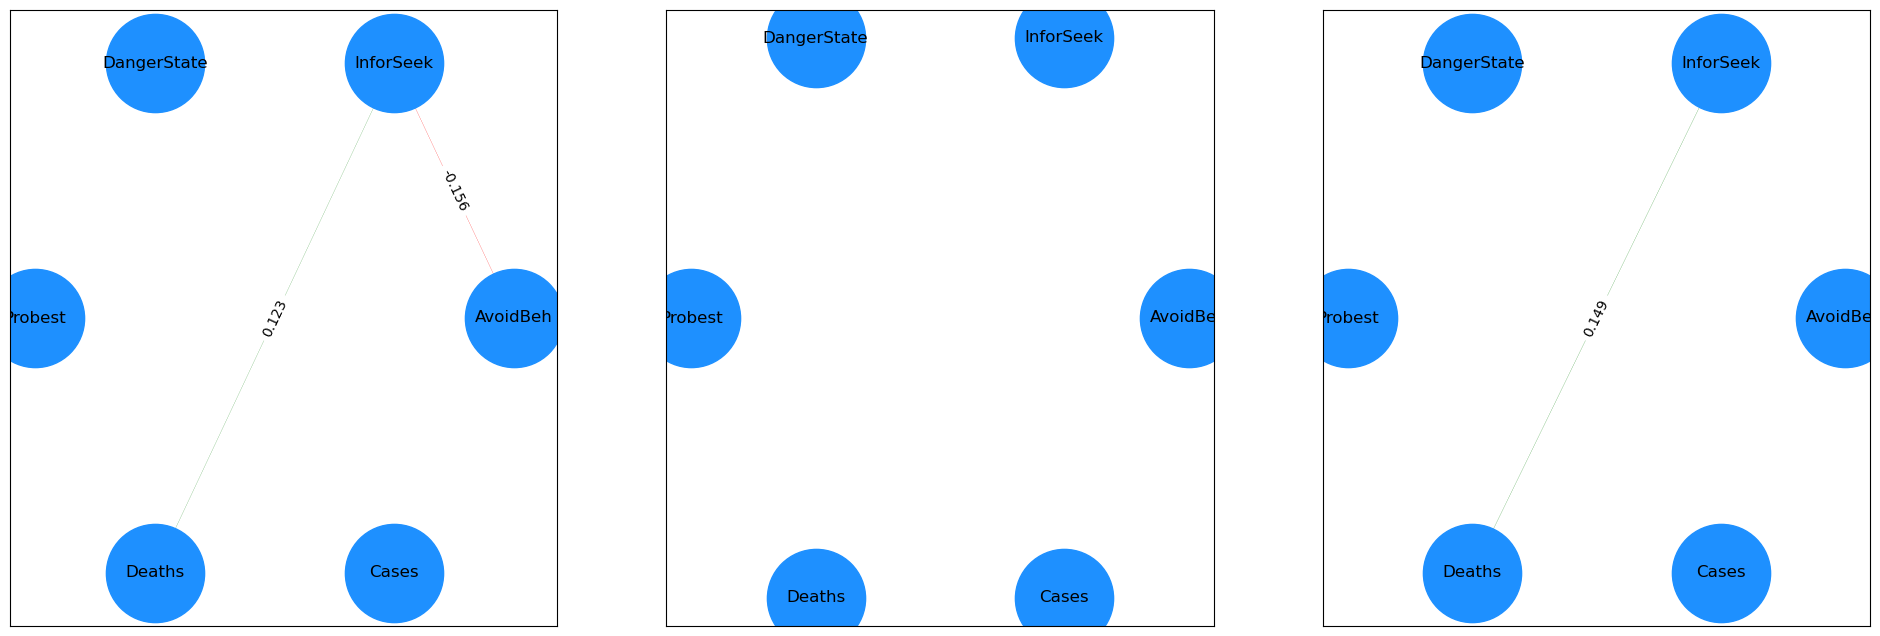

In [ ]:
def runcorr(df, columns, method): 
    tdf = pg.corr(df[columns[0]], df[columns[1]], method=method)
    tdf["trait"] = columns[1]
    return tdf

v2s = "r"

fig, ax = plt.subplots(1,3,figsize=(24,8))
for tidx, tt in enumerate(["TF1", "TF2", "TF3"]):
    
    axx=ax[tidx]
    # get unique combinations (for unidirectional plots)
    combs = pd.DataFrame(list(product(vars, vars)), columns=['v1', 'v2'])
    idx = np.array(combs["v1"] != combs["v2"])
    combs = combs.loc[idx].reset_index()

    # calcualte t-tests
    bounds = contemp_df.groupby(by=["v1", "v2"])['edge', tt].apply(runcorr, columns =['edge', tt], method="pearson").round(3).reset_index()

    # make sure only unique combinations of v1 and v2 exist
    bounds = pd.merge(combs, bounds, on=["v1", "v2"], how="left")

    # estimate betas
    bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
    bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

    # do multiple comparison
    ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"].astype(float), method="fdr_bh")).T
    ffdf.columns =["H", "corr_p"]
    bounds = pd.concat([bounds,ffdf ], axis=1)

    # filter for only significant relationships
    bounds["sig"]  = ["ns" if p>=0.05 else "s" for p in bounds["p-val"]]
    bounds = bounds.loc[bounds["sig"]=="s",:]
    sigcombs = dict([((v1, v2), "x") for v1, v2 in zip(bounds["v1"], bounds["v2"])])
    edge_colors = ["green" if x>=0 else "red" for x in bounds[v2s]]


    import matplotlib
    import matplotlib.cm as cm

    # Prepare bodes, edges and layouts 
    G = nx.DiGraph()
    G.add_nodes_from(vars)
    G.add_edges_from(sigcombs)
    edge_labels = dict([((v1, v2), round(float(bounds.loc[(bounds["v1"]==v1) & (bounds["v2"]==v2),v2s]),3)) for v1, v2 in zip(bounds["v1"],bounds["v2"])])
    edge_widths = np.array([round(float(bounds.loc[(bounds["v1"]==v1) & (bounds["v2"]==v2),v2s]),3) for v1, v2 in zip(bounds["v1"],bounds["v2"])])

    nodesize = 5000
    arc_rad = 0
    pos=nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=axx, node_shape="o", node_size=nodesize, node_color='dodgerblue')
    nx.draw_networkx_labels(G, pos, ax=axx)

    nx.draw_networkx_edges(G, pos, ax=axx, width=edge_widths*0.5, edgelist=sigcombs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=False, arrowsize=10, node_size=nodesize)
    #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

    my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=axx,  rad=arc_rad)
    
plt.show()

### Temporal network 

In [ ]:
temp_df


Unnamed: 0        iv           dv      edge        PROLIFICID
0              1  AvoidBeh     AvoidBeh  0.302992  01S0stEpc3rU6YxK
1              2  AvoidBeh    InforSeek  0.000000  01S0stEpc3rU6YxK
2              3  AvoidBeh      Probest  0.000000  01S0stEpc3rU6YxK
3              4  AvoidBeh  DangerState -0.530696  01S0stEpc3rU6YxK
4              5  AvoidBeh       Deaths  0.268364  01S0stEpc3rU6YxK
...          ...       ...          ...       ...               ...
9355        9356     Cases    InforSeek  0.000000  ztPVSoIVH3QKpGeQ
9356        9357     Cases      Probest  0.000000  ztPVSoIVH3QKpGeQ
9357        9358     Cases  DangerState  0.000000  ztPVSoIVH3QKpGeQ
9358        9359     Cases       Deaths  0.207019  ztPVSoIVH3QKpGeQ
9359        9360     Cases        Cases  0.546168  ztPVSoIVH3QKpGeQ

[9360 rows x 5 columns]

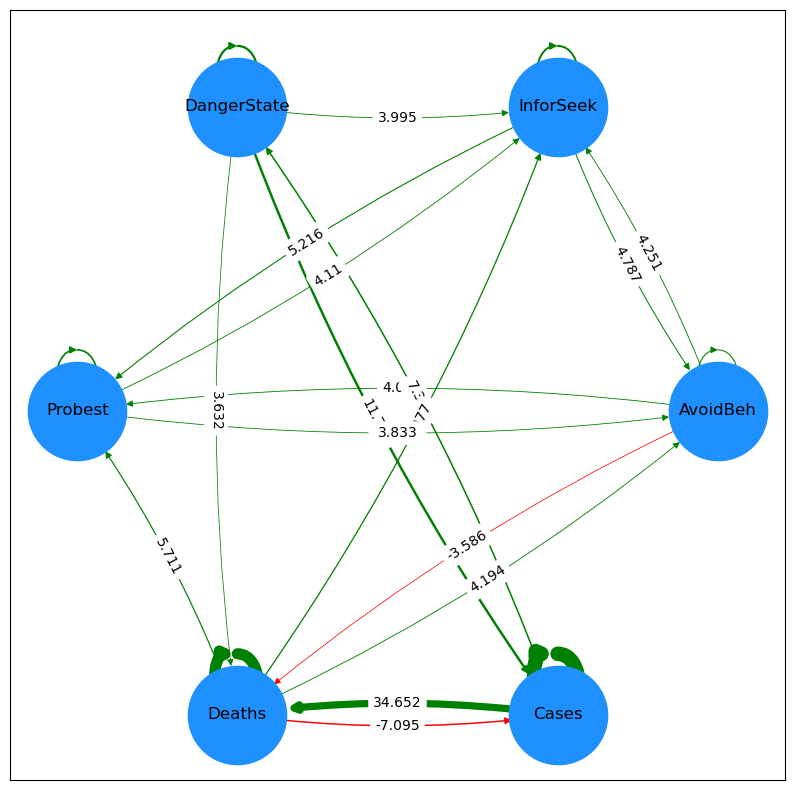

In [ ]:
# get data
v2s = "T"
def extract_values(row):
    return pd.Series(row['CI95%'])

# get unique combinations (for unidirectional plots)
combs = pd.DataFrame(list(product(vars, vars)), columns=['iv', 'dv'])
idx = np.array(combs["iv"] != combs["dv"])
combs = combs.loc[idx].reset_index()

# calcualte t-tests
bounds = temp_df.groupby(by=["iv", "dv"])['edge'].apply(pg.ttest, 0, paired=False).round(3).reset_index()

# make sure only unique combinations of v1 and v2 exist
#bounds = pd.merge(combs, bounds, on=["iv", "dv"], how="left")

# estimate betas
bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

# do multiple comparison
ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"].astype(float), method="fdr_bh")).T
ffdf.columns =["H", "corr_p"]
bounds = pd.concat([bounds,ffdf ], axis=1)

# filter for only significant relationships
bounds["sig"]  = ["ns" if p>=0.05 else "s" for p in bounds["corr_p"]]
bounds = bounds.loc[bounds["sig"]=="s",:]
sigcombs = dict([((iv, dv), "x") for iv, dv in zip(bounds["iv"], bounds["dv"])])
edge_colors = ["green" if x>=0 else "red" for x in bounds[v2s]]


import matplotlib
import matplotlib.cm as cm

# Prepare bodes, edges and layouts 
G = nx.DiGraph()
G.add_nodes_from(vars)
G.add_edges_from(sigcombs)
edge_labels = dict([((iv, dv), round(float(bounds.loc[(bounds["iv"]==iv) & (bounds["dv"]==dv),v2s]),3)) for iv, dv in zip(bounds["iv"],bounds["dv"])])
edge_widths = np.array([round(float(bounds.loc[(bounds["dv"]==dv) & (bounds["iv"]==iv),v2s]),3) for iv, dv in zip(bounds["iv"],bounds["dv"])])

nodesize = 5000
arc_rad = 0.07
pos=nx.circular_layout(G)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
nx.draw_networkx_labels(G, pos, ax=ax)

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*0.15, edgelist=sigcombs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
#fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)

#ax.set_title(lbl + "(t-scores)")
plt.show()

### temporal effects of traits

In [ ]:
temp_df = temp_df.set_index("PROLIFICID").join(id_df)

In [ ]:
bounds

iv           dv   level_2    n      r           CI95%  p-val  \
0      AvoidBeh     AvoidBeh  spearman  260 -0.041   [-0.16, 0.08]  0.512   
1      AvoidBeh        Cases  spearman  260 -0.086   [-0.21, 0.04]  0.165   
2      AvoidBeh  DangerState  spearman  260  0.066   [-0.06, 0.19]  0.287   
3      AvoidBeh       Deaths  spearman  260  0.030   [-0.09, 0.15]  0.632   
4      AvoidBeh    InforSeek  spearman  260  0.065   [-0.06, 0.19]  0.296   
5      AvoidBeh      Probest  spearman  260 -0.153  [-0.27, -0.03]  0.013   
6         Cases     AvoidBeh  spearman  260 -0.080    [-0.2, 0.04]  0.198   
7         Cases        Cases  spearman  260 -0.048   [-0.17, 0.07]  0.440   
8         Cases  DangerState  spearman  260 -0.083    [-0.2, 0.04]  0.181   
9         Cases       Deaths  spearman  260  0.051   [-0.07, 0.17]  0.416   
10        Cases    InforSeek  spearman  260  0.016   [-0.11, 0.14]  0.798   
11        Cases      Probest  spearman  260 -0.036   [-0.16, 0.09]  0.567   
12  DangerState     AvoidBeh  spearman  260 -0.022    [-0.14, 0.1]  0.718   
13  DangerState        Cases  spearman  260 -0.160  [-0.28, -0.04]  0.010   
14  DangerState  DangerState  spearman  260 -0.146  [-0.26, -0.03]  0.018   
15  DangerState       Deaths  spearman  260  0.049   [-0.07, 0.17]  0.427   
16  DangerState    InforSeek  spearman  260 -0.150  [-0.27, -0.03]  0.016   
17  DangerState      Probest  spearman  260  0.062   [-0.06, 0.18]  0.322   
18       Deaths     AvoidBeh  spearman  260 -0.074   [-0.19, 0.05]  0.233   
19       Deaths        Cases  spearman  260  0.053   [-0.07, 0.17]  0.395   
20       Deaths  DangerState  spearman  260  0.028   [-0.09, 0.15]  0.657   
21       Deaths       Deaths  spearman  260 -0.259  [-0.37, -0.14]  0.000   
22       Deaths    InforSeek  spearman  260  0.033   [-0.09, 0.15]  0.595   
23       Deaths      Probest  spearman  260 -0.043   [-0.16, 0.08]  0.489   
24    InforSeek     AvoidBeh  spearman  260 -0.141  [-0.26, -0.02]  0.023   
25    InforSeek        Cases  spearman  260 -0.124   [-0.24, -0.0]  0.045   
26    InforSeek  DangerState  spearman  260  0.058   [-0.06, 0.18]  0.352   
27    InforSeek       Deaths  spearman  260  0.173    [0.05, 0.29]  0.005   
28    InforSeek    InforSeek  spearman  260 -0.097   [-0.22, 0.02]  0.117   
29    InforSeek      Probest  spearman  260  0.044   [-0.08, 0.16]  0.479   
30      Probest     AvoidBeh  spearman  260  0.016   [-0.11, 0.14]  0.799   
31      Probest        Cases  spearman  260  0.007   [-0.11, 0.13]  0.909   
32      Probest  DangerState  spearman  260  0.142    [0.02, 0.26]  0.022   
33      Probest       Deaths  spearman  260  0.044   [-0.08, 0.16]  0.480   
34      Probest    InforSeek  spearman  260  0.037   [-0.08, 0.16]  0.548   
35      Probest      Probest  spearman  260 -0.054   [-0.17, 0.07]  0.386   

    power trait   CI5  CI95  betaest      H    corr_p sig  
0   0.101   TF3 -0.16  0.08   -0.040  False  0.682667  ns  
1   0.285   TF3 -0.21  0.04   -0.085  False      0.54  ns  
2   0.187   TF3 -0.06  0.19    0.065  False     0.666  ns  
3   0.077   TF3 -0.09  0.15    0.030  False  0.733935  ns  
4   0.182   TF3 -0.06  0.19    0.065  False     0.666  ns  
5   0.700   TF3 -0.27 -0.03   -0.150  False    0.1035  ns  
6   0.251   TF3 -0.20  0.04   -0.080  False  0.548308  ns  
7   0.121   TF3 -0.17  0.07   -0.050  False  0.677077  ns  
8   0.267   TF3 -0.20  0.04   -0.080  False     0.543  ns  
9   0.129   TF3 -0.07  0.17    0.050  False  0.677077  ns  
10  0.057   TF3 -0.11  0.14    0.015  False  0.821829  ns  
11  0.088   TF3 -0.16  0.09   -0.035  False  0.703862  ns  
12  0.065   TF3 -0.14  0.10   -0.020  False  0.783273  ns  
13  0.736   TF3 -0.28 -0.04   -0.160  False    0.1035  ns  
14  0.658   TF3 -0.26 -0.03   -0.145  False    0.1035  ns  
15  0.125   TF3 -0.07  0.17    0.050  False  0.677077  ns  
16  0.680   TF3 -0.27 -0.03   -0.150  False    0.1035  ns  
17  0.168   TF3 -0.06  0.18    0.060  False  0.677077  ns  
18  0.223   TF3 -0.19  

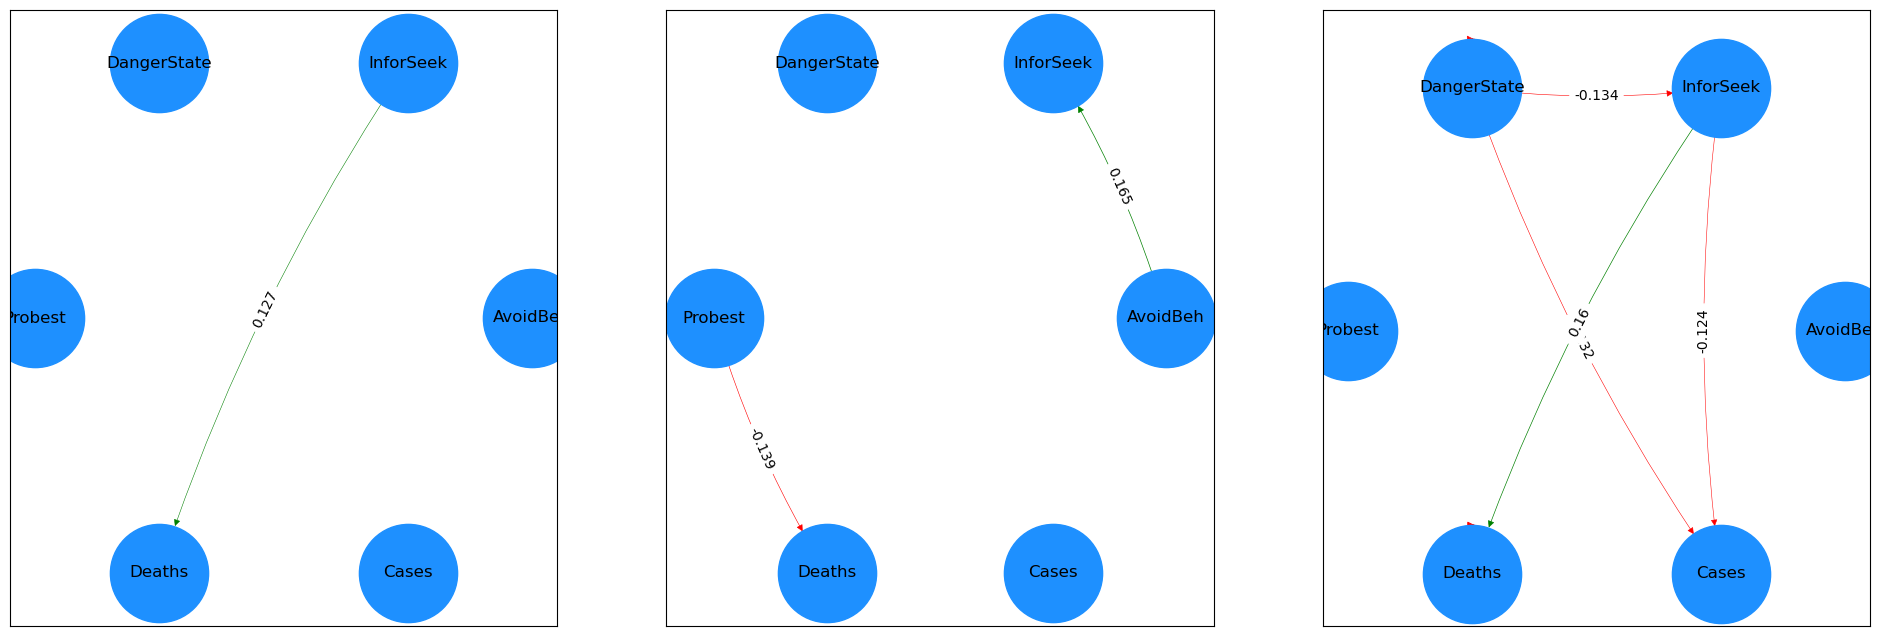

In [ ]:


v2s = "r"

fig, ax = plt.subplots(1,3,figsize=(24,8))
for tidx, tt in enumerate(["TF1", "TF2", "TF3"]):

    axx=ax[tidx]
    # get unique combinations (for unidirectional plots)
    combs = pd.DataFrame(list(product(vars, vars)), columns=['iv', 'dv'])
    idx = np.array(combs["iv"] != combs["dv"])
    combs = combs.loc[idx].reset_index()

    # calcualte t-tests
    bounds = temp_df.groupby(by=["iv", "dv"])['edge', tt].apply(runcorr, columns =['edge', tt], method="pearson").round(3).reset_index()


    # estimate betas
    bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
    bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

    # do multiple comparison
    ffdf = pd.DataFrame(pg.multicomp(bounds["p-val"].astype(float), method="fdr_bh")).T
    ffdf.columns =["H", "corr_p"]
    bounds = pd.concat([bounds,ffdf ], axis=1)

    # filter for only significant relationships
    bounds["sig"]  = ["ns" if p>=0.05 else "s" for p in bounds["p-val"]]
    bounds = bounds.loc[bounds["sig"]=="s",:]
    sigcombs = dict([((iv, dv), "x") for iv, dv in zip(bounds["iv"], bounds["dv"])])
    edge_colors = ["green" if x>=0 else "red" for x in bounds[v2s]]


    import matplotlib
    import matplotlib.cm as cm

    # Prepare bodes, edges and layouts 
    G = nx.DiGraph()
    G.add_nodes_from(vars)
    G.add_edges_from(sigcombs)
    edge_labels = dict([((iv, dv), round(float(bounds.loc[(bounds["iv"]==iv) & (bounds["dv"]==dv),v2s]),3)) for iv, dv in zip(bounds["iv"],bounds["dv"])])
    edge_widths = np.array([round(float(bounds.loc[(bounds["dv"]==dv) & (bounds["iv"]==iv),v2s]),3) for iv, dv in zip(bounds["iv"],bounds["dv"])])

    nodesize = 5000
    arc_rad = 0.07
    pos=nx.circular_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=axx, node_shape="o", node_size=nodesize, node_color='dodgerblue')
    nx.draw_networkx_labels(G, pos, ax=axx)

    nx.draw_networkx_edges(G, pos, ax=axx, width=edge_widths*3, edgelist=sigcombs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
    #fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

    my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=axx,  rad=arc_rad)

    #ax.set_title(lbl + "(t-scores)")
plt.show()

In [ ]:
bounds

iv           dv   level_2    n      r           CI95%  p-val  \
0      AvoidBeh     AvoidBeh  spearman  260 -0.041   [-0.16, 0.08]  0.512   
1      AvoidBeh        Cases  spearman  260 -0.086   [-0.21, 0.04]  0.165   
2      AvoidBeh  DangerState  spearman  260  0.066   [-0.06, 0.19]  0.287   
3      AvoidBeh       Deaths  spearman  260  0.030   [-0.09, 0.15]  0.632   
4      AvoidBeh    InforSeek  spearman  260  0.065   [-0.06, 0.19]  0.296   
5      AvoidBeh      Probest  spearman  260 -0.153  [-0.27, -0.03]  0.013   
6         Cases     AvoidBeh  spearman  260 -0.080    [-0.2, 0.04]  0.198   
7         Cases        Cases  spearman  260 -0.048   [-0.17, 0.07]  0.440   
8         Cases  DangerState  spearman  260 -0.083    [-0.2, 0.04]  0.181   
9         Cases       Deaths  spearman  260  0.051   [-0.07, 0.17]  0.416   
10        Cases    InforSeek  spearman  260  0.016   [-0.11, 0.14]  0.798   
11        Cases      Probest  spearman  260 -0.036   [-0.16, 0.09]  0.567   
12  DangerState     AvoidBeh  spearman  260 -0.022    [-0.14, 0.1]  0.718   
13  DangerState        Cases  spearman  260 -0.160  [-0.28, -0.04]  0.010   
14  DangerState  DangerState  spearman  260 -0.146  [-0.26, -0.03]  0.018   
15  DangerState       Deaths  spearman  260  0.049   [-0.07, 0.17]  0.427   
16  DangerState    InforSeek  spearman  260 -0.150  [-0.27, -0.03]  0.016   
17  DangerState      Probest  spearman  260  0.062   [-0.06, 0.18]  0.322   
18       Deaths     AvoidBeh  spearman  260 -0.074   [-0.19, 0.05]  0.233   
19       Deaths        Cases  spearman  260  0.053   [-0.07, 0.17]  0.395   
20       Deaths  DangerState  spearman  260  0.028   [-0.09, 0.15]  0.657   
21       Deaths       Deaths  spearman  260 -0.259  [-0.37, -0.14]  0.000   
22       Deaths    InforSeek  spearman  260  0.033   [-0.09, 0.15]  0.595   
23       Deaths      Probest  spearman  260 -0.043   [-0.16, 0.08]  0.489   
24    InforSeek     AvoidBeh  spearman  260 -0.141  [-0.26, -0.02]  0.023   
25    InforSeek        Cases  spearman  260 -0.124   [-0.24, -0.0]  0.045   
26    InforSeek  DangerState  spearman  260  0.058   [-0.06, 0.18]  0.352   
27    InforSeek       Deaths  spearman  260  0.173    [0.05, 0.29]  0.005   
28    InforSeek    InforSeek  spearman  260 -0.097   [-0.22, 0.02]  0.117   
29    InforSeek      Probest  spearman  260  0.044   [-0.08, 0.16]  0.479   
30      Probest     AvoidBeh  spearman  260  0.016   [-0.11, 0.14]  0.799   
31      Probest        Cases  spearman  260  0.007   [-0.11, 0.13]  0.909   
32      Probest  DangerState  spearman  260  0.142    [0.02, 0.26]  0.022   
33      Probest       Deaths  spearman  260  0.044   [-0.08, 0.16]  0.480   
34      Probest    InforSeek  spearman  260  0.037   [-0.08, 0.16]  0.548   
35      Probest      Probest  spearman  260 -0.054   [-0.17, 0.07]  0.386   

    power trait   CI5  CI95  betaest      H    corr_p sig  
0   0.101   TF3 -0.16  0.08   -0.040  False  0.682667  ns  
1   0.285   TF3 -0.21  0.04   -0.085  False      0.54  ns  
2   0.187   TF3 -0.06  0.19    0.065  False     0.666  ns  
3   0.077   TF3 -0.09  0.15    0.030  False  0.733935  ns  
4   0.182   TF3 -0.06  0.19    0.065  False     0.666  ns  
5   0.700   TF3 -0.27 -0.03   -0.150  False    0.1035   s  
6   0.251   TF3 -0.20  0.04   -0.080  False  0.548308  ns  
7   0.121   TF3 -0.17  0.07   -0.050  False  0.677077  ns  
8   0.267   TF3 -0.20  0.04   -0.080  False     0.543  ns  
9   0.129   TF3 -0.07  0.17    0.050  False  0.677077  ns  
10  0.057   TF3 -0.11  0.14    0.015  False  0.821829  ns  
11  0.088   TF3 -0.16  0.09   -0.035  False  0.703862  ns  
12  0.065   TF3 -0.14  0.10   -0.020  False  0.783273  ns  
13  0.736   TF3 -0.28 -0.04   -0.160  False    0.1035   s  
14  0.658   TF3 -0.26 -0.03   -0.145  False    0.1035   s  
15  0.125   TF3 -0.07  0.17    0.050  False  0.677077  ns  
16  0.680   TF3 -0.27 -0.03   -0.150  False    0.1035   s  
17  0.168   TF3 -0.06  0.18    0.060  False  0.677077  ns  
18  0.223   TF3 -0.19  

In [ ]:
# get data
v2s = "T"
def extract_values(row):
    return pd.Series(row['CI95%'])

# this one gets the stats
bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].apply(pg.ttest, 0, paired=False).round(3).reset_index()
bounds[['CI5', 'CI95']] = bounds.apply(extract_values, axis=1)
bounds["betaest"] = bounds.loc[:,['CI5', 'CI95']].mean(axis=1)

# this one just gets the mean betas
#bounds = gdf.groupby(by=["var", "iv", "dv"])['beta'].agg(['mean', 'sem']).reset_index()
#bounds["CI5"] = bounds["mean"] - bounds["sem"]
#bounds["CI95"] = bounds["mean"] + bounds["sem"]

# filter for same session and only "significant" 
bdf = bounds.loc[bounds["var"]=="iv_lag0",:]
bdf["sig"]  = ["ns" if l<0<u else "s" for l,u in zip(bdf["CI5"], bdf["CI95"])]
bdf = bdf.loc[bdf["sig"]=="s",:]
combs = dict([((iv, dv), "x") for dv, iv in zip(bdf["dv"], bdf["iv"])])
edge_colors = ["green" if x>=0 else "red" for x in bdf[v2s]]

import matplotlib
import matplotlib.cm as cm

# Prepare bodes, edges and layouts 
G = nx.DiGraph()
G.add_nodes_from(vars)
G.add_edges_from(combs)
edge_labels = dict([((iv, dv), round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3)) for iv, dv in zip(bdf["iv"],bdf["dv"])])
edge_widths = np.array([round(float(bdf.loc[(bdf["iv"]==iv) & (bdf["dv"]==dv),v2s]),3) for iv, dv in zip(bdf["iv"],bdf["dv"])])
#norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=True)
#mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)

nodesize = 5000
arc_rad = 0.07
pos=nx.circular_layout(G)
fig, ax = plt.subplots(1,1,figsize=(10,10))
nx.draw_networkx_nodes(G, pos, ax=ax, node_shape="o", node_size=nodesize, node_color='dodgerblue')
nx.draw_networkx_labels(G, pos, ax=ax)

nx.draw_networkx_edges(G, pos, ax=ax, width=edge_widths*0.7, edgelist=combs, edge_color=edge_colors, connectionstyle=f'arc3, rad = {arc_rad}', arrows=True, arrowsize=10, node_size=nodesize)
#fig.savefig("2.png", bbox_inches='tight',pad_inches=0)

my_draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, ax=ax,  rad=arc_rad)
ax.set_title("Lag0; cohen d")
plt.show()

NameError: name 'gdf' is not defined